<a href="https://colab.research.google.com/github/rdsza/PytorchExamples/blob/main/QuickStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This section runs through the API for common tasks in ML. 

## Working with data
PyTorch has two primitives to work with data : `torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset`.

In [17]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


PyTorch offers domain-specific libraries such as TorchText, TorchVision and TorchAudio, all of which include datasets. For this tutorial, we will be using TorchVision dataset.

The `torchvision.datasets` module contains `Dataset` objects for many real-world vision data like CIFAR, COCO etc. In this tutorial, we will use the FashionMNIST dataset. Every TorchVision `Dataset` includes two arguments: `transform` and `target_transform` to modify the samples and labels respectively.

In [18]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download the test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the `Dataset` argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e., each element in the dataloader iterable will return a batch of 64 features and labels.

In [19]:
batch_size = 64

# create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data,batch_size=batch_size)

for X, y in test_dataloader:
  print(f"Shape of X[N, C, H, W]: {X.shape}")
  print(f"Shape of y:{y.shape} {y.dtype}")
  break

Shape of X[N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y:torch.Size([64]) torch.int64


# Iterating and Visualing the Dataset

We can index `Datasets` manually like a list: `training_data[index]`. We use `matplotlib` to visualize some samples in our training data.

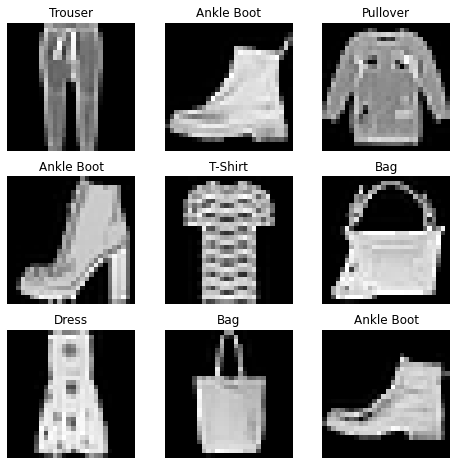

In [20]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()


# Creating a Custom Dataset for your files

A custom Dataset class must implement three functions: __init__,__len__, and __getitem__. Take a look at this implementatiom; the FashionMNIST images are stored in a directory `img_dir`, and their labels are stored separately in a CSV file `annotations_file`.

In [21]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

## __init__

The __init__ function is run once when instatiating the Dataset object. We initialize the directory containing the images, the annotations file, and both transforms (covered in more detail in the next section).

The labels.csv file looks like

tshirt1.jpg, 0 \
tshirt2.jpg, 0 \
..... \
ankleboot.jpg, 9

In [22]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
  self.img_labels = pd.read_csv(annotations_file)
  self.img_dir = img_dir
  self.transform = transform
  self.target_transform = target_transform

## __len__

The __len__ function returns the number of samples in our dataset.

Example:


In [23]:
def __len__(self):
  return len(self.img_labels)

## __getitem__

The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image's location on disk, converts that to a tensor using `read_image`, retrieves the corresponding label from the csv data in `self.img_labels`, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

In [24]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

## Preparing your data for training with Dataloaders

The `Dataset` retrieves our dataset's features and labels on sample at a time. While training a model, we typically want to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's `multiprocessing` to speed up data retrieval.

`Dataloader` is an iterable that abstracts this complexity for us in an easy API.

In [27]:
from torch.utils.data import DataLoader 

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Iterate through the Dataloader

We have loaded that dataset into the `DataLoader` and can iterate throught the dataset as needed. eEahc iteration bvelow reyutns a batch of `train_features` and `train_labels` (containing `batch_size=64` features and labels respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffles (for finer=grained control over the data loading order, take a look at Samples).

Features batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


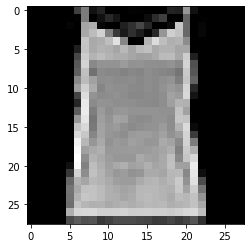

Label :0


In [30]:
# Display the iomage and label

train_features, train_labels = next(iter(train_dataloader))
print(f"Features batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label :{label}")